In [1]:
from gan import Generator, Discriminator, Features, SignalHead, DeconvHead
from hierarchical_negbin import RecordGenerator

import os
import pdb
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

from matplotlib import cm
viridis = cm.get_cmap('viridis', 12)
cols = ["#926cb6", "#93b793", "#d31d00", "#ff900d", "#fefb03", "black"]
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
first_run = True

In [3]:
MAXBINS = 400
BATCHSIZE = 48  # max size is 64

In [4]:
simulator = RecordGenerator(n_obs=(10000, 10000),
                            n_bins=(50, MAXBINS),
                            n_meanings=(1, 4),
                            noise_ratio=(0.05, 0.1),
                            noise_dispersion=(0.05, 1.5),
                            alpha_meanings=(1.0, 4.0),
                            rounding=list(range(15)),
                            inner_mode_dist_tol=0.2,
                            inner_sigma_ratio=3.0,
                            max_sigma_to_bins_ratio=0.25,
                            sigmas=(0.5, 100.0),
                            trim_corners=True)

In [5]:
geninput_noise = tf.keras.Input(shape=(MAXBINS, 1), dtype=tf.float32)
geninput_signal = tf.keras.Input(shape=(MAXBINS, 1), dtype=tf.float32)
geninput_noiseratio = tf.keras.Input(shape=(1, 1), dtype=tf.float32)
disinput = tf.keras.Input(shape=(MAXBINS, 1), dtype=tf.float32)

genoutput = Generator(ksize=5, filters=48, nblocks=16, batch_norms=False)([geninput_noise, geninput_signal, geninput_noiseratio])
disoutput = Discriminator(ksize=7, filters=32, nblocks=16, batch_norms=False)(disinput)

generator = tf.keras.Model(inputs=[geninput_noise, geninput_signal, geninput_noiseratio], outputs=genoutput)
discriminator = tf.keras.Model(inputs=disinput, outputs=disoutput)

inputs_smoother = tf.keras.Input(shape=(MAXBINS, 1), dtype=tf.float32)
inputs_deconv = tf.keras.Input(shape=(MAXBINS, 2), dtype=tf.float32)

feats_smoother = Features(ksize=7, filters=32, nblocks=12, batch_norms=False)(inputs_smoother)
feats_deconv = Features(ksize=7, filters=32, nblocks=12, batch_norms=False)(inputs_deconv)

signal_head = SignalHead(ksize=5, filters=32, nblocks_signal=2, nblocks_peaks=4, batch_norms=False)
deconv_head =  DeconvHead(ksize=5, filters=32, nblocks=4, batch_norms=False)

signal, peaks = signal_head([feats_smoother, inputs_smoother])
deconv = deconv_head([feats_deconv, inputs_deconv])

smoother = tf.keras.Model(inputs=inputs_smoother, outputs=[signal, peaks])
deconv = tf.keras.Model(inputs=inputs_deconv, outputs=deconv)

In [6]:
# generator.load_weights("generator.h5")
# discriminator.load_weights("discriminator.h5")
smoother.load_weights("smoother_post_gan_bi.h5")
deconv.load_weights("deconv_post_gan_bi.h5")
generator.load_weights("ckpts/generator_0125.h5")
discriminator.load_weights("ckpts/discriminator_0125.h5")
# smoother.load_weights("ckpts/smoother_0040.h5")
# generator.load_weights("ckpts/generator_0104.h5")
# discriminator.load_weights("ckpts/discriminator_0104.h5")
# smoother.load_weights("ckpts/smoother_0104.h5")
# deconvolver.load_weights("deconvolver.h5")
# smoother.load_weights("tmp_back_to_two_smoother.h5")

In [7]:
# generator.summary(line_length=150)

In [8]:
# discriminator.summary(line_length=150)

In [9]:
def standardize_bins(obs):
    if len(obs) > MAXBINS:
        start = (len(obs) - MAXBINS) // 2
        obs = obs[start:(start + MAXBINS)]
    L = len(obs)
    assert L <= MAXBINS
    start = MAXBINS // 2 - L // 2
    end = start + L
    out = np.zeros(MAXBINS, dtype=type(obs[0]))
    out[start:end] = obs
    return out, start


def get_inputs(batch_raw):
    batch = [x['counts'] for x in batch_raw]
    bin_sizes_stacked = []
    noises = []
    signals = []
    signals_stacked = []
    real_obs = []
    real_obs_stacked = []
    modes = []
    modes_stacked = []
    nr = []
    bin_sizes = []
    num_meanings = []
    simulator_data = []
#     generated_images = []
#     generated_images_stacked = []
    for j, obs in enumerate(batch):
        sim_to_gen_ratio = np.random.rand()
        n = len(obs)
        x = np.array(obs, dtype=np.float32)
        x = np.maximum(x - 2.0, 0.0)
        x /= x.sum()
        if np.any(np.isnan(x)):
            print("Warning: not enough counts on x, skipping...")
            continue
        x, start_bin = standardize_bins(x)
        z = np.random.normal(size=n).astype(np.float32)
        z, _ = standardize_bins(z)
        while True:
            try:
                dat = simulator.generate(n_bins=n)
                break
            except RuntimeError as e:
                print("error with ", n, "bins")
                print(e)             
        pdf = dat['pdf'].astype(np.float32)
        pdf -= pdf.min()
        pdf /= pdf.sum()
        pdf, _ = standardize_bins(pdf)
        if np.any(np.isnan(pdf)):
            pdb.set_trace()
        m = dat['centroids_onehot']
        m, _ = standardize_bins(m)
        sim_obs = dat['obs']
        sim_obs = sim_obs.astype(np.float32)
        sim_obs /= sim_obs.sum()
        sim_obs = standardize_bins(sim_obs)[0]
        meaning_modes = dat['meaning_centroids']
        meaning_modes = [int(np.round(np.clip(x, 0, n - 1))) for x in meaning_modes]
#         print(meaning_modes)
        meaning_pdfs = dat['meaning_pdfs']
        Nm = len(meaning_modes)
        pdfm_stacked = np.zeros((Nm, MAXBINS), dtype=np.float32)
        m_stacked = np.zeros((Nm, MAXBINS), dtype=np.float32)
        for l, (mm, d) in enumerate(zip(meaning_modes, meaning_pdfs)):
            u = np.zeros(n, dtype=np.float32)
            u[mm] = 1.0
            m_stacked[l, :] = standardize_bins(u)[0]
            #
            d = d.astype(np.float32)
            d -= d.min()
            d /= d.sum()
            pdfm_stacked[l, :] = standardize_bins(d)[0]
        nr0 = np.random.uniform(0.1, 0.75)
        nr.append(nr0)
        modes.append(m)
        noises.append(z)
        signals.append(pdf)
        real_obs.append(x)
        bin_sizes.append(n)
        modes_stacked.append(m_stacked)
        real_obs_stacked.append(np.stack(Nm * [x], 0))
        bin_sizes_stacked.append(Nm * [n])
        num_meanings.append(Nm)
        signals_stacked.append(pdfm_stacked)
        simulator_data.append(sim_obs)
#         z_max = np.reshape(z, (1, -1, 1))
#         pdf_max = np.reshape(pdf, (1, -1, 1)) * n
#         nr_max = np.reshape(nr0, (1, 1, 1)).astype(np.float32)
#         gi = generator([z_max, pdf_max, nr_max])
#         generated_images.append(gi)
#         gi_s = np.concatenate(Nm * [gi], 0)
#         generated_images_stacked.append(gi_s)
    noises = np.stack(noises, 0)       
    noises = np.expand_dims(noises, -1)
    signals = np.stack(signals, 0)       
    signals = np.expand_dims(signals, -1)
    modes = np.stack(modes, 0)       
    modes = np.expand_dims(modes, -1)
    real_obs = np.stack(real_obs, 0)       
    real_obs = np.expand_dims(real_obs, -1)
    bin_sizes = np.reshape(np.array(bin_sizes, dtype=np.float32), (-1, 1, 1))
    real_obs_stacked = np.expand_dims(np.concatenate(real_obs_stacked, 0), -1)
    signals_stacked = np.expand_dims(np.concatenate(signals_stacked, 0), -1)
    modes_stacked = np.expand_dims(np.concatenate(modes_stacked, 0), -1)
    bin_sizes_stacked = np.reshape(np.concatenate(bin_sizes_stacked, 0), (-1, 1, 1))
#     generated_images = np.concatenate(generated_images, 0)
#     generated_images_stacked = np.concatenate(generated_images_stacked, 0)
    sim_obs = np.expand_dims(np.stack(simulator_data, 0), -1)
    nr = np.reshape(np.array(nr, dtype=np.float32), (-1, 1, 1))
    #
    pdf_max = signals * bin_sizes
    generated_images = generator([noises, pdf_max, nr]).numpy()
    W = np.reshape(np.random.rand(generated_images.shape[0]), (-1,1,1))
    generated_images = W * sim_obs + (1.0 - W) * generated_images
    generated_images_stacked = []
    for k, Nm in enumerate(num_meanings):
        gi_k = generated_images[k,:,:]
        gi_k = np.stack(Nm * [gi_k], 0)
        generated_images_stacked.append(gi_k)
    generated_images_stacked = np.concatenate(generated_images_stacked, 0)
    w = np.random.rand()
    #
    return real_obs, noises, signals, nr, modes, bin_sizes, real_obs_stacked, signals_stacked, modes_stacked, bin_sizes_stacked, num_meanings, generated_images, generated_images_stacked


def read_batch(file):
    with open(file, "r") as f:
        x = json.load(f)
    return x

In [10]:
cross_entropy_from_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def binary_loss(y, phat):
    #
    loss = - 2.5 * y * tf.math.log(phat + 1e-12)
    loss += - (1.0 - y) * tf.math.log(1.0 - phat + 1e-12)
    loss = tf.math.reduce_mean(tf.math.reduce_sum(loss, 1))
    return loss

    
def num_meanings_loss(num_meanings, phat):
    phat_sum = tf.math.reduce_sum(phat, 1)
    loss = tf.math.reduce_mean((phat_sum - num_meanings) ** 2)
    return loss
    

def tv_reg(x):
    x0 = x[:,:-1,:]
    x1 = x[:,1:,:]
    d0 = tf.reduce_mean(tf.reduce_sum((x1 - x0)**2, 1))
    #
    z = (x1 - x0)
    z0 = z[:,:-1,:]
    z1 = z[:,1:,:]
    d1 = tf.reduce_mean(tf.reduce_sum((z1 - z0)**2, 1))
    #
    return 0.25 * d0 + d1


def skl(y, yhat):
    x = - 0.5 * y * tf.math.log((yhat + 1e-6) / (y + 1e-6))
    x += - 0.5 * yhat * tf.math.log((y + 1e-6) / (yhat + 1e-6))
    loss = tf.reduce_mean(tf.math.reduce_sum(x, 1))
    return loss


smoother_optimizer = tf.keras.optimizers.Adam(5e-4, beta_1=0.75, clipnorm=3.0)
deconv_optimizer = tf.keras.optimizers.Adam(5e-4, beta_1=0.75, clipnorm=3.0)


# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function(experimental_relax_shapes=True)
def train_step(real_signal, noise, pdf, nr, modes, bin_sizes, generated_images, num_meanings,
               real_signals_stacked, pdfs_stacked, modes_stacked, bin_sizes_stacked, generated_images_stacked):
    # normalization
    pdf_normalized = pdf * bin_sizes
    real_signal_normalized = real_signal * bin_sizes
    real_signals_stacked_normalized = real_signals_stacked * bin_sizes_stacked
    pdfs_stacked_normalized = pdfs_stacked * bin_sizes_stacked
    
    # generate fake images
    generated_images_normalized = generated_images * bin_sizes
    generated_images_stacked_normalized = generated_images_stacked * bin_sizes_stacked
    
    # compute smoother loss      
    with tf.GradientTape() as sm_tape, tf.GradientTape() as sm_tape_robust_opt:
        # 
        sm_tape_robust_opt.watch(generated_images_normalized)
        smooth_fake, peaks_fake = smoother(generated_images_normalized)
        smooth_real, peaks_real = smoother(real_signal_normalized)
        #
        sm_loss = skl(pdf, smooth_fake)
        peaks_fake_phat = tf.math.sigmoid(peaks_fake)
        peaks_loss = 0.1 * binary_loss(modes, peaks_fake_phat)
        meanings_loss = num_meanings_loss(num_meanings, peaks_fake_phat)
        sm_loss += peaks_loss + meanings_loss
#         sm_reg = 0.05 * tv_reg(smooth_fake)
#         sm_reg += 0.001 * tv_reg(peaks_fake)
        sm_reg = 1.0 * tv_reg(smooth_real)
#         sm_reg += 0.00001 * tv_reg(peaks_real)
        sm_reg += 0.0001 * sum(generator.losses)
        sm_loss += sm_reg
        
        data_grad = sm_tape_robust_opt.gradient(sm_loss, [generated_images_normalized])[0]
        robust_opt_penalty = 1e-4 * tf.reduce_mean(tf.reduce_sum(data_grad ** 2, 1))
        sm_loss += robust_opt_penalty

    # compute and apply gradients
    gradients_of_smoother = sm_tape.gradient(sm_loss, smoother.trainable_variables)    
    smooth_check_disc = [tf.debugging.check_numerics(d, "smoother grad") for d in gradients_of_smoother]
    with tf.control_dependencies(smooth_check_disc):
        smoother_optimizer.apply_gradients(zip(gradients_of_smoother, smoother.trainable_variables))
        
    # compute deconv loss    
    with tf.GradientTape() as deconv_tape, tf.GradientTape() as deconv_tape_robust_opt:
        deconv_tape_robust_opt.watch(generated_images_stacked_normalized)
        deconv_inputs_generated = tf.concat([generated_images_stacked_normalized, modes_stacked], -1)
        deconv_output = deconv(deconv_inputs_generated)
        deconv_loss = skl(pdfs_stacked_normalized, deconv_output)
        deconv_reg = 0.5 * tv_reg(deconv_output)
        deconv_reg += 0.0001 * sum(deconv.losses)
        deconv_loss += deconv_reg
        
        data_grad = deconv_tape_robust_opt.gradient(deconv_loss, [generated_images_stacked_normalized])[0]
        robust_opt_penalty_deconv = 1e-4 * tf.reduce_mean(tf.reduce_sum(data_grad ** 2, 1))
        deconv_loss += robust_opt_penalty_deconv
        
    # compute and apply gradients
    gradients_of_deconv = deconv_tape.gradient(deconv_loss, deconv.trainable_variables)
    deconv_check_disc = [tf.debugging.check_numerics(d, "deconv grad") for d in gradients_of_deconv]
    with tf.control_dependencies(deconv_check_disc):
        deconv_optimizer.apply_gradients(zip(gradients_of_deconv, deconv.trainable_variables))
        
   

    return sm_loss, deconv_loss, sm_reg, deconv_reg, peaks_loss, meanings_loss, robust_opt_penalty

In [11]:
def print_checks(model, prefix=""):
    # --- do some checks ---
    wts = model.get_weights()
    Mw = max(x.max() for x in wts)
    mw = min(x.min() for x in wts)
#     means = []
#     varis = []
#     for w in model.weights:
#         if "moving_mean" in w.name:
#             means.append(w.numpy().mean())
#         if "moving_var" in w.name:
#             varis.append(w.numpy().mean())
#     means = np.mean(means)
#     stds = np.sqrt(np.mean(varis))
    wnames = []
    for w in model.weights:
        if np.any(np.isnan(w.numpy())):
            wnames.append(w.name)
    if len(wnames) > 0:
            print(f"{prefix} | nans at: ", wnames)
#     print(f"{prefix} | wts: ({mw:.2f}, {Mw:.2f}) | mov_means: {means:.2f}, mov_stds: {stds:.4f}")
    print(f"{prefix} | wts: ({mw:.2f}, {Mw:.2f})")

In [12]:
fdir = "../SmoothDoQ/doq_noun_batches/"
files = os.listdir(fdir)
files = [os.path.join(fdir, x) for x in files]

===== Epoch 0: =====
iter: 0, completed: 0.03%, smoother_loss: 1.2473, deconv_loss: 644.5471, smoother_reg: 0.0047, deconv_reg: 0.0073, peaks_loss: 0.8807, mn_loss: 0.1195, ro_pen: 0.0596
Smother | wts: (-14.47, 2.28)
Deconv | wts: (-4.82, 1.36)


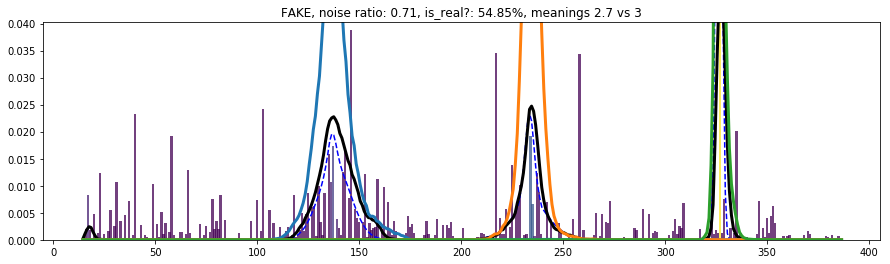

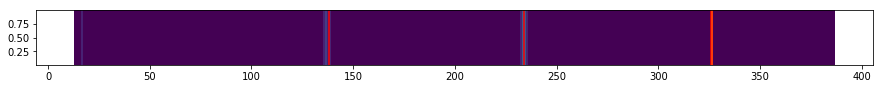

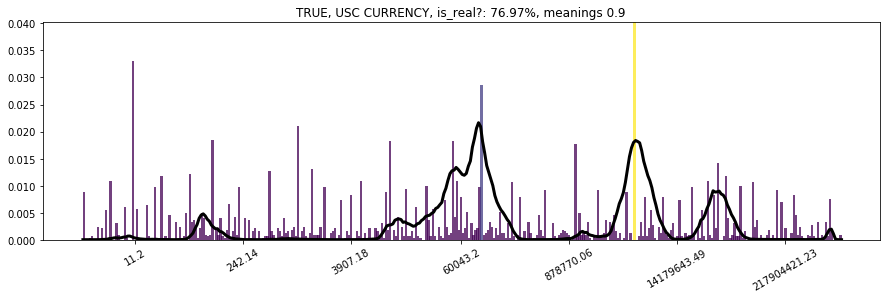

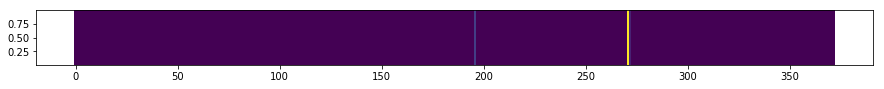

error with  185 bins
iter: 5, completed: 0.19%, smoother_loss: 1.2498, deconv_loss: 639.6538, smoother_reg: 0.0048, deconv_reg: 0.0072, peaks_loss: 0.8769, mn_loss: 0.1216, ro_pen: 0.0644
Smother | wts: (-14.47, 2.28)
Deconv | wts: (-4.82, 1.36)
iter: 10, completed: 0.34%, smoother_loss: 1.2433, deconv_loss: 634.7440, smoother_reg: 0.0047, deconv_reg: 0.0072, peaks_loss: 0.8709, mn_loss: 0.1216, ro_pen: 0.0647
Smother | wts: (-14.47, 2.28)
Deconv | wts: (-4.82, 1.36)
iter: 15, completed: 0.50%, smoother_loss: 1.2455, deconv_loss: 631.8998, smoother_reg: 0.0047, deconv_reg: 0.0071, peaks_loss: 0.8704, mn_loss: 0.1215, ro_pen: 0.0676
Smother | wts: (-14.47, 2.28)
Deconv | wts: (-4.82, 1.36)
 smoother grad : Tensor had NaN values
	 [[node CheckNumerics_144 (defined at C:\Users\garci\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]] [Op:__inference_train_step_175144]

Function call stack:
train_step

file  ../SmoothDoQ/doq_noun_batches/003133.json
iter: 20, compl

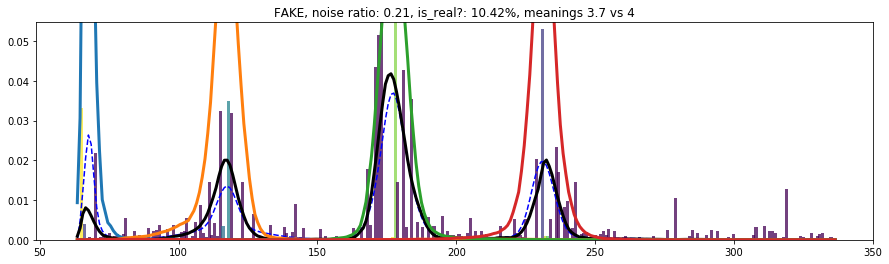

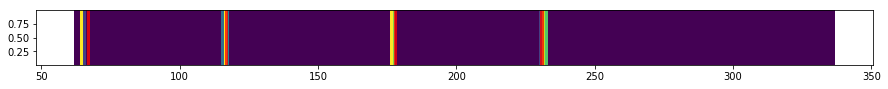

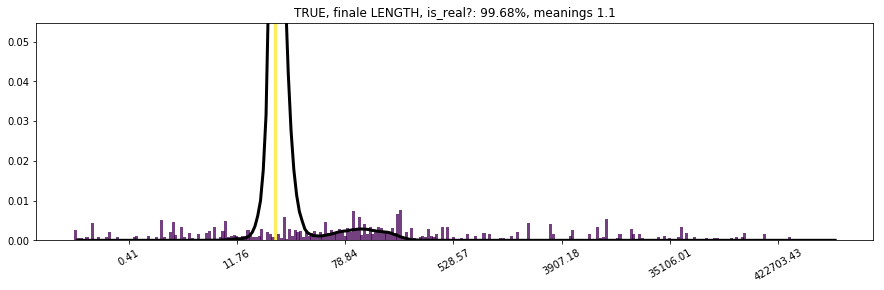

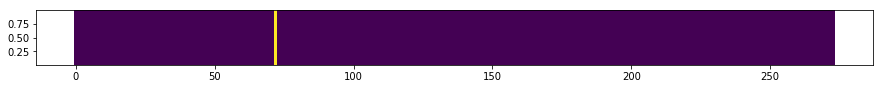

iter: 30, completed: 0.97%, smoother_loss: 1.2653, deconv_loss: 620.6317, smoother_reg: 0.0046, deconv_reg: 0.0066, peaks_loss: 0.8751, mn_loss: 0.1300, ro_pen: 0.0775
Smother | wts: (-14.46, 2.27)
Deconv | wts: (-4.83, 1.36)
iter: 35, completed: 1.13%, smoother_loss: 1.2613, deconv_loss: 617.2972, smoother_reg: 0.0046, deconv_reg: 0.0065, peaks_loss: 0.8712, mn_loss: 0.1319, ro_pen: 0.0766
Smother | wts: (-14.46, 2.27)
Deconv | wts: (-4.83, 1.36)
iter: 40, completed: 1.28%, smoother_loss: 1.2579, deconv_loss: 616.6418, smoother_reg: 0.0047, deconv_reg: 0.0064, peaks_loss: 0.8707, mn_loss: 0.1325, ro_pen: 0.0751
Smother | wts: (-14.46, 2.27)
Deconv | wts: (-4.83, 1.36)
error with  278 bins
iter: 45, completed: 1.44%, smoother_loss: 1.2545, deconv_loss: 615.1232, smoother_reg: 0.0047, deconv_reg: 0.0063, peaks_loss: 0.8680, mn_loss: 0.1330, ro_pen: 0.0738
Smother | wts: (-14.46, 2.27)
Deconv | wts: (-4.83, 1.36)
iter: 50, completed: 1.60%, smoother_loss: 1.2537, deconv_loss: 613.4641, s

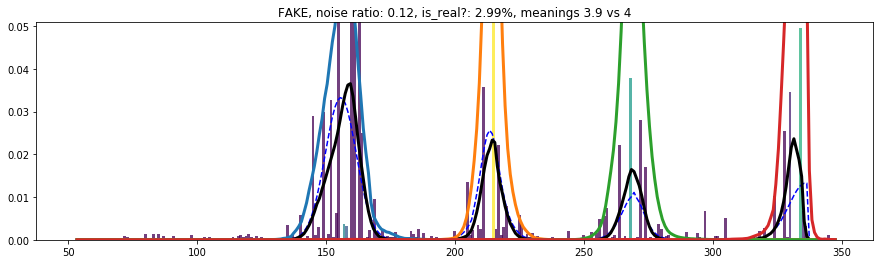

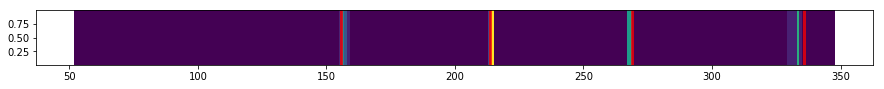

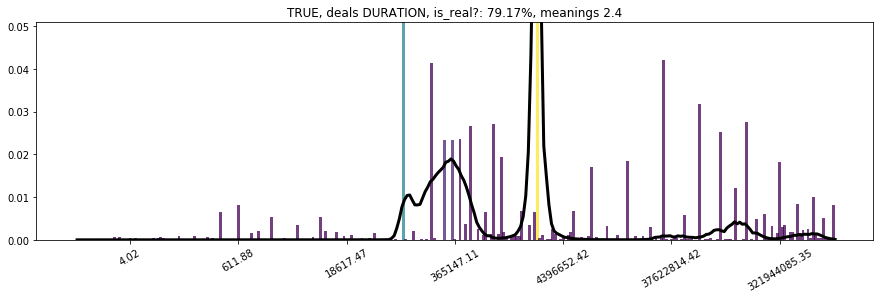

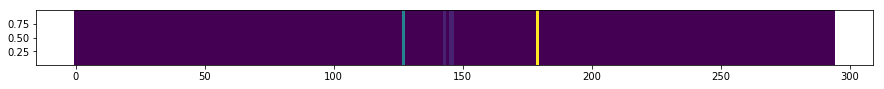

iter: 55, completed: 1.75%, smoother_loss: 1.2561, deconv_loss: 611.4370, smoother_reg: 0.0048, deconv_reg: 0.0061, peaks_loss: 0.8701, mn_loss: 0.1349, ro_pen: 0.0738
Smother | wts: (-14.45, 2.27)
Deconv | wts: (-4.83, 1.36)
error with  350 bins
iter: 60, completed: 1.91%, smoother_loss: 1.2586, deconv_loss: 607.9169, smoother_reg: 0.0049, deconv_reg: 0.0061, peaks_loss: 0.8699, mn_loss: 0.1410, ro_pen: 0.0717
Smother | wts: (-14.45, 2.27)
Deconv | wts: (-4.83, 1.36)
iter: 65, completed: 2.07%, smoother_loss: 1.2589, deconv_loss: 606.3129, smoother_reg: 0.0049, deconv_reg: 0.0059, peaks_loss: 0.8715, mn_loss: 0.1414, ro_pen: 0.0706
Smother | wts: (-14.45, 2.27)
Deconv | wts: (-4.83, 1.36)
iter: 70, completed: 2.22%, smoother_loss: 1.2652, deconv_loss: 604.4540, smoother_reg: 0.0050, deconv_reg: 0.0059, peaks_loss: 0.8713, mn_loss: 0.1447, ro_pen: 0.0734
Smother | wts: (-14.45, 2.27)
Deconv | wts: (-4.83, 1.36)
iter: 75, completed: 2.38%, smoother_loss: 1.2627, deconv_loss: 601.0023, s

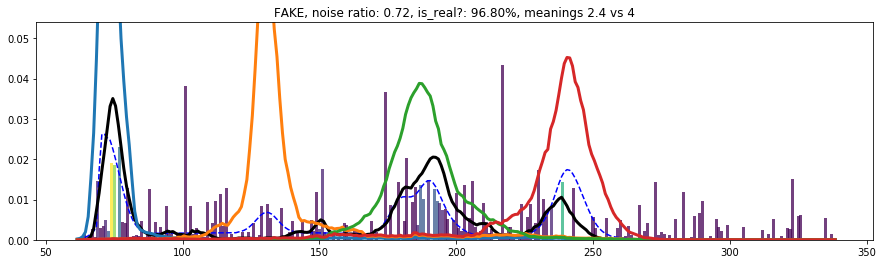

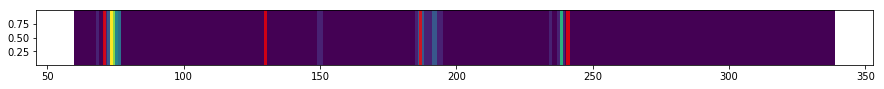

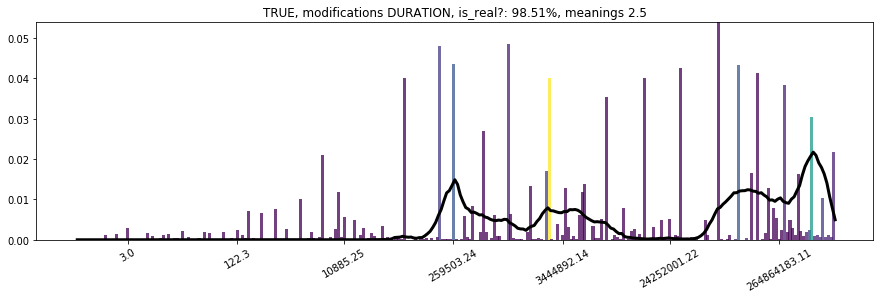

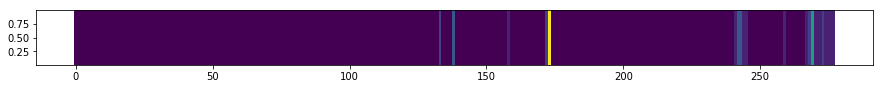

iter: 80, completed: 2.53%, smoother_loss: 1.2581, deconv_loss: 598.0623, smoother_reg: 0.0052, deconv_reg: 0.0057, peaks_loss: 0.8701, mn_loss: 0.1450, ro_pen: 0.0697
Smother | wts: (-14.45, 2.27)
Deconv | wts: (-4.83, 1.36)
error with  274 bins
iter: 85, completed: 2.69%, smoother_loss: 1.2521, deconv_loss: 593.5599, smoother_reg: 0.0053, deconv_reg: 0.0058, peaks_loss: 0.8665, mn_loss: 0.1444, ro_pen: 0.0685
Smother | wts: (-14.45, 2.26)
Deconv | wts: (-4.83, 1.36)
iter: 90, completed: 2.85%, smoother_loss: 1.2565, deconv_loss: 591.8674, smoother_reg: 0.0053, deconv_reg: 0.0057, peaks_loss: 0.8691, mn_loss: 0.1472, ro_pen: 0.0676
Smother | wts: (-14.45, 2.26)
Deconv | wts: (-4.83, 1.36)
iter: 95, completed: 3.00%, smoother_loss: 1.2487, deconv_loss: 591.7695, smoother_reg: 0.0053, deconv_reg: 0.0056, peaks_loss: 0.8638, mn_loss: 0.1470, ro_pen: 0.0662
Smother | wts: (-14.45, 2.26)
Deconv | wts: (-4.83, 1.36)
iter: 100, completed: 3.16%, smoother_loss: 1.2447, deconv_loss: 591.7281, 

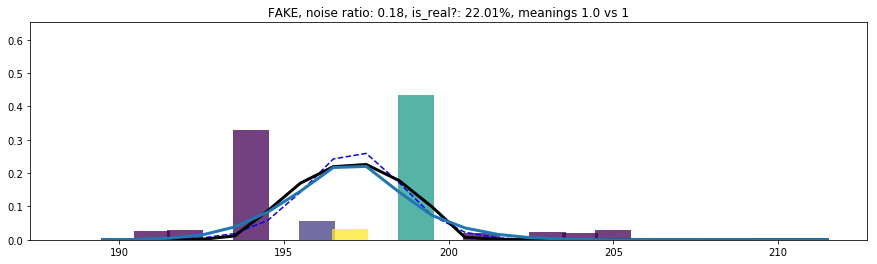

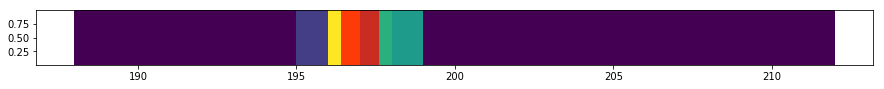

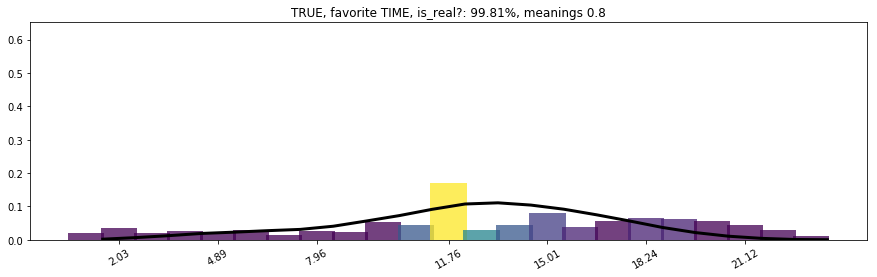

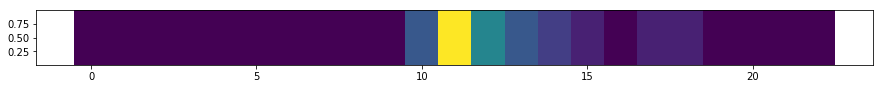

iter: 105, completed: 3.32%, smoother_loss: 1.2447, deconv_loss: 590.8242, smoother_reg: 0.0053, deconv_reg: 0.0055, peaks_loss: 0.8641, mn_loss: 0.1484, ro_pen: 0.0635
Smother | wts: (-14.44, 2.26)
Deconv | wts: (-4.83, 1.35)
iter: 110, completed: 3.47%, smoother_loss: 1.2452, deconv_loss: 589.9336, smoother_reg: 0.0052, deconv_reg: 0.0054, peaks_loss: 0.8650, mn_loss: 0.1498, ro_pen: 0.0633
Smother | wts: (-14.44, 2.26)
Deconv | wts: (-4.83, 1.35)
iter: 115, completed: 3.63%, smoother_loss: 1.2409, deconv_loss: 590.7387, smoother_reg: 0.0053, deconv_reg: 0.0053, peaks_loss: 0.8645, mn_loss: 0.1478, ro_pen: 0.0619
Smother | wts: (-14.44, 2.26)
Deconv | wts: (-4.83, 1.35)
iter: 120, completed: 3.79%, smoother_loss: 1.2308, deconv_loss: 584.4767, smoother_reg: 0.0053, deconv_reg: 0.0052, peaks_loss: 0.8590, mn_loss: 0.1451, ro_pen: 0.0601
Smother | wts: (-14.44, 2.26)
Deconv | wts: (-4.83, 1.35)
error with  406 bins
iter: 125, completed: 3.94%, smoother_loss: 1.2261, deconv_loss: 585.06

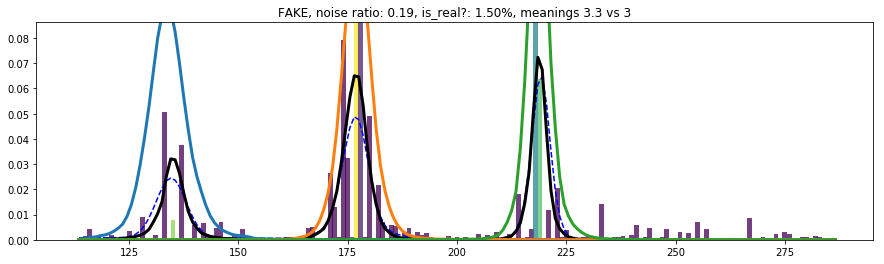

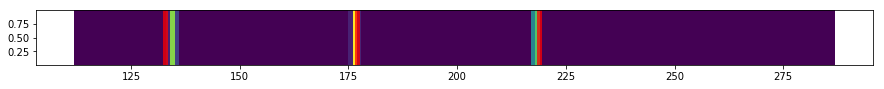

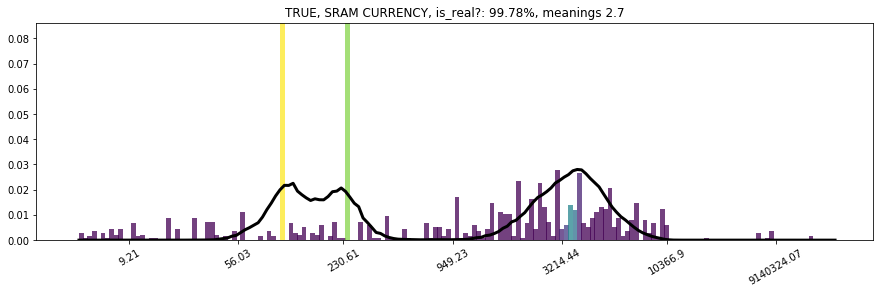

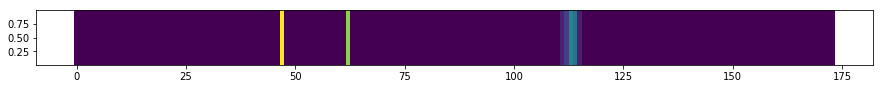

error with  213 bins
iter: 130, completed: 4.10%, smoother_loss: 1.2209, deconv_loss: 584.5551, smoother_reg: 0.0055, deconv_reg: 0.0052, peaks_loss: 0.8566, mn_loss: 0.1415, ro_pen: 0.0575
Smother | wts: (-14.44, 2.26)
Deconv | wts: (-4.83, 1.35)
iter: 135, completed: 4.26%, smoother_loss: 1.2278, deconv_loss: 584.5577, smoother_reg: 0.0056, deconv_reg: 0.0051, peaks_loss: 0.8593, mn_loss: 0.1451, ro_pen: 0.0579
Smother | wts: (-14.44, 2.26)
Deconv | wts: (-4.83, 1.35)
iter: 140, completed: 4.41%, smoother_loss: 1.2259, deconv_loss: 582.7013, smoother_reg: 0.0058, deconv_reg: 0.0050, peaks_loss: 0.8600, mn_loss: 0.1446, ro_pen: 0.0566
Smother | wts: (-14.44, 2.26)
Deconv | wts: (-4.83, 1.35)
iter: 145, completed: 4.57%, smoother_loss: 1.2288, deconv_loss: 581.8987, smoother_reg: 0.0059, deconv_reg: 0.0049, peaks_loss: 0.8643, mn_loss: 0.1441, ro_pen: 0.0567
Smother | wts: (-14.44, 2.26)
Deconv | wts: (-4.83, 1.35)
iter: 150, completed: 4.72%, smoother_loss: 1.2271, deconv_loss: 582.45

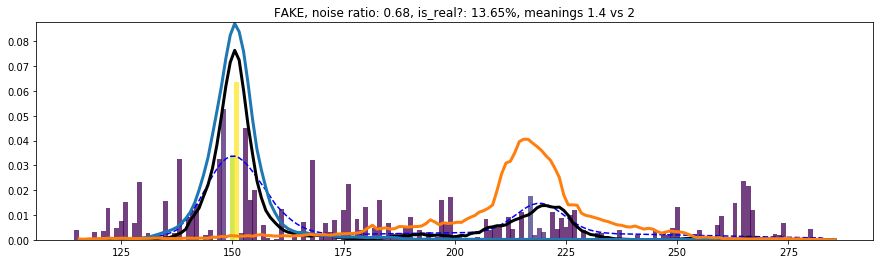

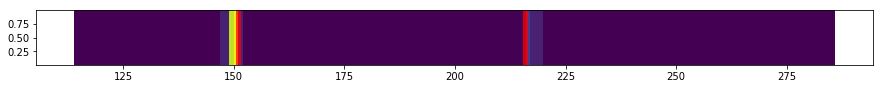

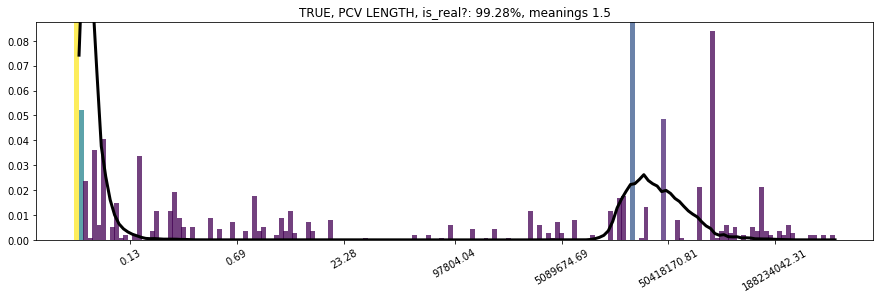

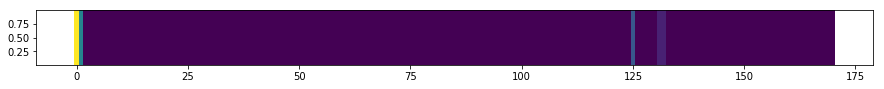

iter: 155, completed: 4.88%, smoother_loss: 1.2274, deconv_loss: 583.7380, smoother_reg: 0.0061, deconv_reg: 0.0048, peaks_loss: 0.8624, mn_loss: 0.1455, ro_pen: 0.0556
Smother | wts: (-14.44, 2.25)
Deconv | wts: (-4.83, 1.36)
error with  351 bins
iter: 160, completed: 5.04%, smoother_loss: 1.2224, deconv_loss: 584.8597, smoother_reg: 0.0061, deconv_reg: 0.0050, peaks_loss: 0.8581, mn_loss: 0.1450, ro_pen: 0.0550
Smother | wts: (-14.44, 2.25)
Deconv | wts: (-4.83, 1.36)
iter: 165, completed: 5.19%, smoother_loss: 1.2189, deconv_loss: 582.8105, smoother_reg: 0.0061, deconv_reg: 0.0049, peaks_loss: 0.8589, mn_loss: 0.1433, ro_pen: 0.0539
Smother | wts: (-14.44, 2.25)
Deconv | wts: (-4.83, 1.36)
iter: 170, completed: 5.35%, smoother_loss: 1.2161, deconv_loss: 581.2873, smoother_reg: 0.0060, deconv_reg: 0.0048, peaks_loss: 0.8583, mn_loss: 0.1425, ro_pen: 0.0539
Smother | wts: (-14.43, 2.25)
Deconv | wts: (-4.83, 1.36)
iter: 175, completed: 5.51%, smoother_loss: 1.2170, deconv_loss: 581.10

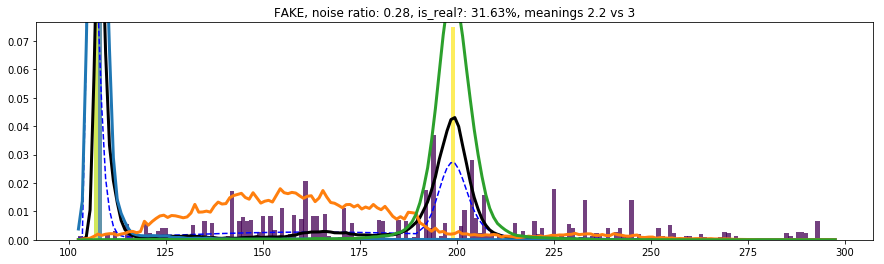

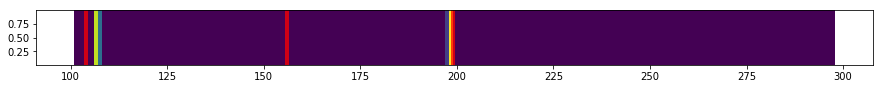

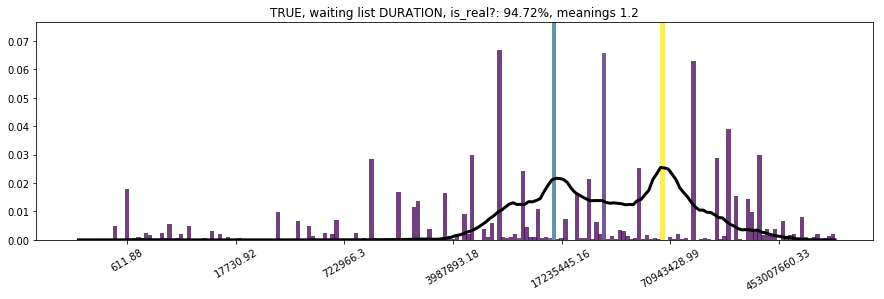

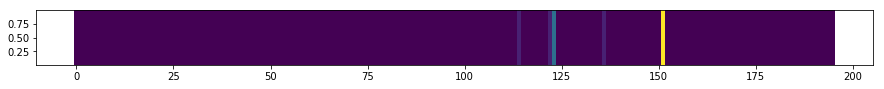

iter: 180, completed: 5.66%, smoother_loss: 1.2182, deconv_loss: 581.3542, smoother_reg: 0.0060, deconv_reg: 0.0047, peaks_loss: 0.8614, mn_loss: 0.1443, ro_pen: 0.0523
Smother | wts: (-14.43, 2.25)
Deconv | wts: (-4.83, 1.36)
iter: 185, completed: 5.82%, smoother_loss: 1.2164, deconv_loss: 582.2282, smoother_reg: 0.0059, deconv_reg: 0.0046, peaks_loss: 0.8612, mn_loss: 0.1439, ro_pen: 0.0510
Smother | wts: (-14.43, 2.25)
Deconv | wts: (-4.83, 1.36)
iter: 190, completed: 5.98%, smoother_loss: 1.2180, deconv_loss: 581.3598, smoother_reg: 0.0059, deconv_reg: 0.0047, peaks_loss: 0.8611, mn_loss: 0.1444, ro_pen: 0.0519
Smother | wts: (-14.43, 2.25)
Deconv | wts: (-4.83, 1.36)
iter: 195, completed: 6.13%, smoother_loss: 1.2179, deconv_loss: 580.5705, smoother_reg: 0.0059, deconv_reg: 0.0046, peaks_loss: 0.8610, mn_loss: 0.1443, ro_pen: 0.0520
Smother | wts: (-14.43, 2.25)
Deconv | wts: (-4.83, 1.36)
error with  439 bins
iter: 200, completed: 6.29%, smoother_loss: 1.2200, deconv_loss: 580.38

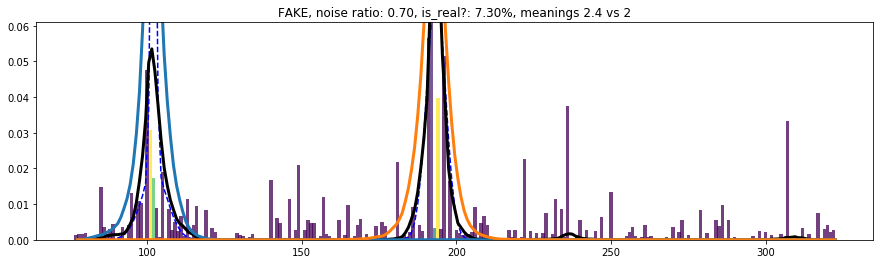

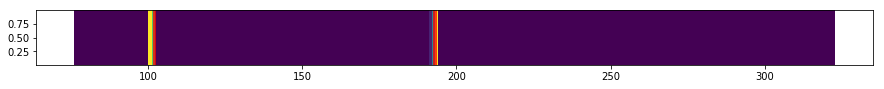

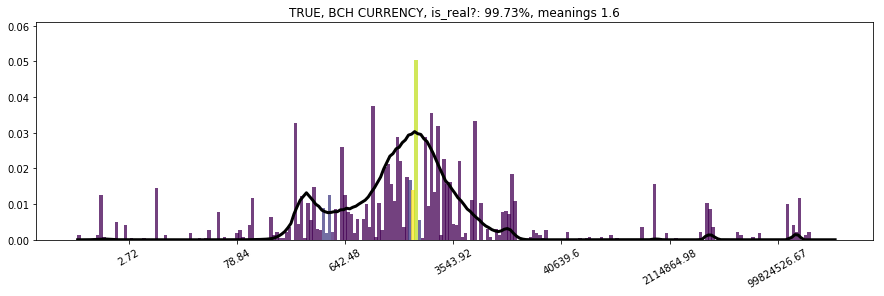

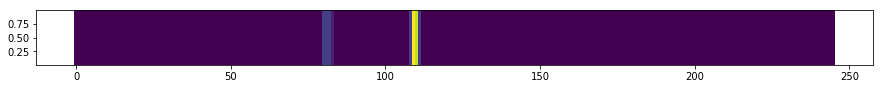

iter: 205, completed: 6.45%, smoother_loss: 1.2164, deconv_loss: 578.8386, smoother_reg: 0.0060, deconv_reg: 0.0046, peaks_loss: 0.8619, mn_loss: 0.1431, ro_pen: 0.0502
Smother | wts: (-14.43, 2.24)
Deconv | wts: (-4.83, 1.36)
iter: 210, completed: 6.60%, smoother_loss: 1.2137, deconv_loss: 579.6779, smoother_reg: 0.0061, deconv_reg: 0.0047, peaks_loss: 0.8604, mn_loss: 0.1415, ro_pen: 0.0510
Smother | wts: (-14.43, 2.24)
Deconv | wts: (-4.83, 1.36)


C:\Users\garci\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


iter: 215, completed: 6.76%, smoother_loss: 1.2078, deconv_loss: 578.7729, smoother_reg: 0.0062, deconv_reg: 0.0047, peaks_loss: 0.8562, mn_loss: 0.1404, ro_pen: 0.0501
Smother | wts: (-14.43, 2.24)
Deconv | wts: (-4.83, 1.36)
iter: 220, completed: 6.91%, smoother_loss: 1.1998, deconv_loss: 577.5223, smoother_reg: 0.0064, deconv_reg: 0.0047, peaks_loss: 0.8517, mn_loss: 0.1386, ro_pen: 0.0497
Smother | wts: (-14.42, 2.24)
Deconv | wts: (-4.83, 1.36)
iter: 225, completed: 7.07%, smoother_loss: 1.1949, deconv_loss: 576.2212, smoother_reg: 0.0064, deconv_reg: 0.0048, peaks_loss: 0.8488, mn_loss: 0.1380, ro_pen: 0.0491
Smother | wts: (-14.42, 2.24)
Deconv | wts: (-4.83, 1.36)


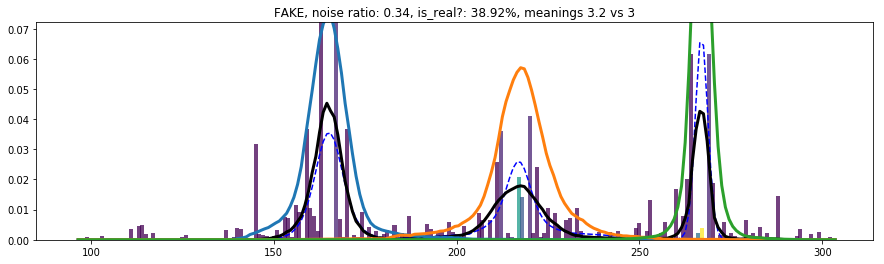

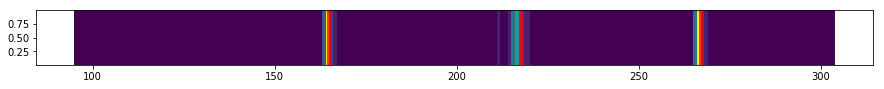

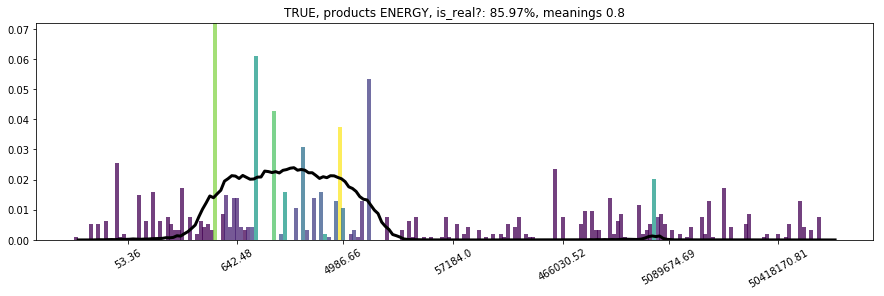

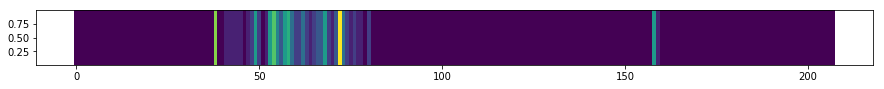

iter: 230, completed: 7.23%, smoother_loss: 1.1971, deconv_loss: 573.9579, smoother_reg: 0.0064, deconv_reg: 0.0048, peaks_loss: 0.8505, mn_loss: 0.1389, ro_pen: 0.0489
Smother | wts: (-14.42, 2.24)
Deconv | wts: (-4.83, 1.36)
iter: 235, completed: 7.38%, smoother_loss: 1.1971, deconv_loss: 574.1376, smoother_reg: 0.0065, deconv_reg: 0.0047, peaks_loss: 0.8505, mn_loss: 0.1380, ro_pen: 0.0499
Smother | wts: (-14.42, 2.24)
Deconv | wts: (-4.83, 1.36)
iter: 240, completed: 7.54%, smoother_loss: 1.1961, deconv_loss: 573.8492, smoother_reg: 0.0065, deconv_reg: 0.0047, peaks_loss: 0.8504, mn_loss: 0.1375, ro_pen: 0.0497
Smother | wts: (-14.42, 2.24)
Deconv | wts: (-4.83, 1.36)
iter: 245, completed: 7.70%, smoother_loss: 1.1982, deconv_loss: 574.0836, smoother_reg: 0.0065, deconv_reg: 0.0047, peaks_loss: 0.8516, mn_loss: 0.1379, ro_pen: 0.0501
Smother | wts: (-14.42, 2.24)
Deconv | wts: (-4.83, 1.36)
iter: 250, completed: 7.85%, smoother_loss: 1.1992, deconv_loss: 575.3259, smoother_reg: 0.0

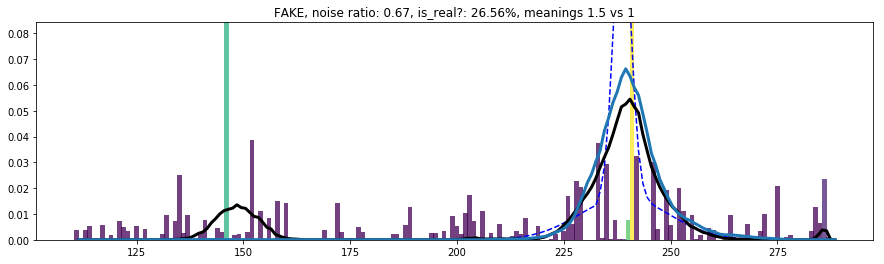

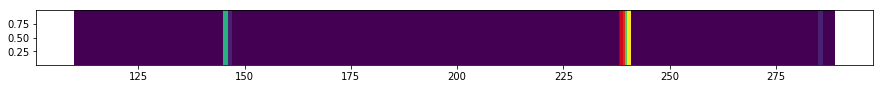

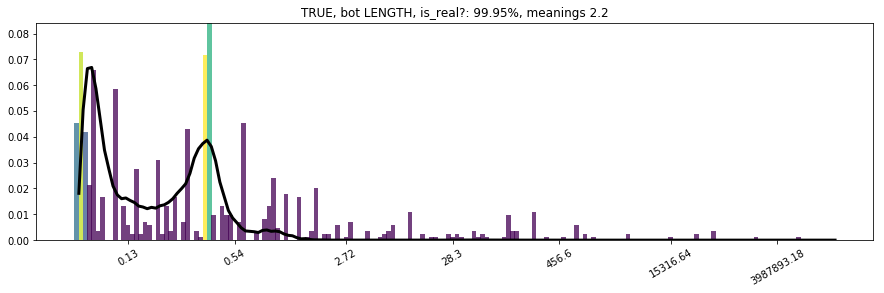

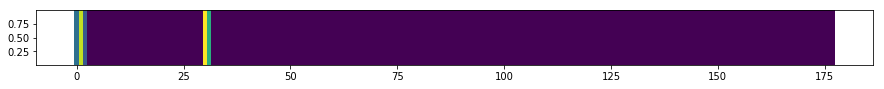

iter: 255, completed: 8.01%, smoother_loss: 1.1988, deconv_loss: 576.6970, smoother_reg: 0.0066, deconv_reg: 0.0047, peaks_loss: 0.8549, mn_loss: 0.1363, ro_pen: 0.0481
Smother | wts: (-14.42, 2.24)
Deconv | wts: (-4.83, 1.36)
iter: 260, completed: 8.17%, smoother_loss: 1.2091, deconv_loss: 576.6539, smoother_reg: 0.0065, deconv_reg: 0.0046, peaks_loss: 0.8579, mn_loss: 0.1424, ro_pen: 0.0505
Smother | wts: (-14.42, 2.24)
Deconv | wts: (-4.83, 1.36)
iter: 265, completed: 8.32%, smoother_loss: 1.2210, deconv_loss: 576.1218, smoother_reg: 0.0065, deconv_reg: 0.0045, peaks_loss: 0.8619, mn_loss: 0.1520, ro_pen: 0.0492
Smother | wts: (-14.41, 2.23)
Deconv | wts: (-4.83, 1.36)
iter: 270, completed: 8.48%, smoother_loss: 1.2204, deconv_loss: 574.3608, smoother_reg: 0.0064, deconv_reg: 0.0044, peaks_loss: 0.8631, mn_loss: 0.1514, ro_pen: 0.0490
Smother | wts: (-14.41, 2.23)
Deconv | wts: (-4.83, 1.36)
iter: 275, completed: 8.64%, smoother_loss: 1.2265, deconv_loss: 573.2364, smoother_reg: 0.0

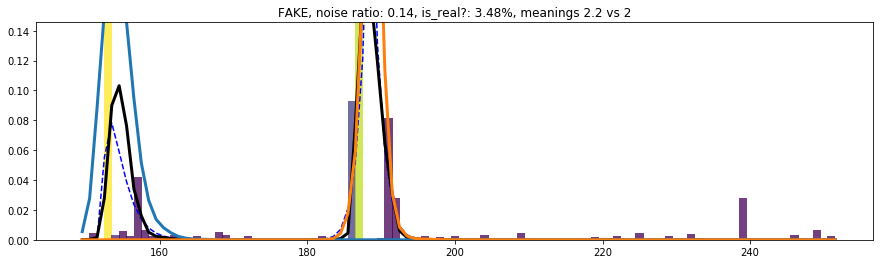

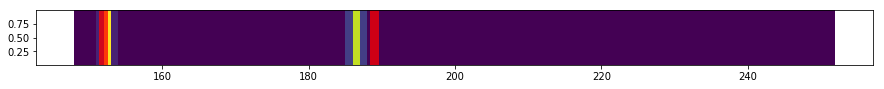

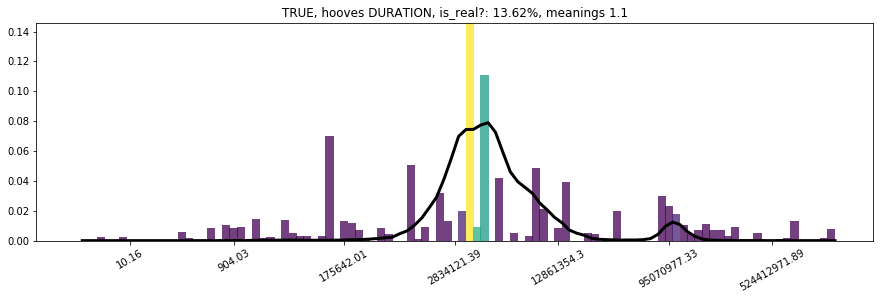

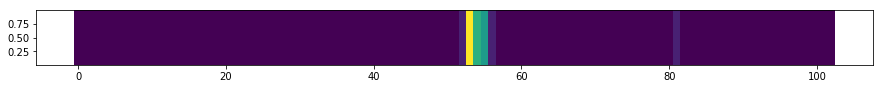

iter: 280, completed: 8.79%, smoother_loss: 1.2314, deconv_loss: 573.7586, smoother_reg: 0.0066, deconv_reg: 0.0044, peaks_loss: 0.8689, mn_loss: 0.1548, ro_pen: 0.0485
Smother | wts: (-14.41, 2.23)
Deconv | wts: (-4.83, 1.36)
iter: 285, completed: 8.95%, smoother_loss: 1.2256, deconv_loss: 571.7074, smoother_reg: 0.0066, deconv_reg: 0.0044, peaks_loss: 0.8642, mn_loss: 0.1539, ro_pen: 0.0480
Smother | wts: (-14.41, 2.23)
Deconv | wts: (-4.83, 1.37)
iter: 290, completed: 9.11%, smoother_loss: 1.2195, deconv_loss: 571.2526, smoother_reg: 0.0068, deconv_reg: 0.0045, peaks_loss: 0.8609, mn_loss: 0.1524, ro_pen: 0.0471
Smother | wts: (-14.41, 2.23)
Deconv | wts: (-4.83, 1.36)
iter: 295, completed: 9.26%, smoother_loss: 1.2173, deconv_loss: 570.9590, smoother_reg: 0.0068, deconv_reg: 0.0046, peaks_loss: 0.8582, mn_loss: 0.1534, ro_pen: 0.0465
Smother | wts: (-14.41, 2.23)
Deconv | wts: (-4.83, 1.36)
iter: 300, completed: 9.42%, smoother_loss: 1.2119, deconv_loss: 567.3909, smoother_reg: 0.0

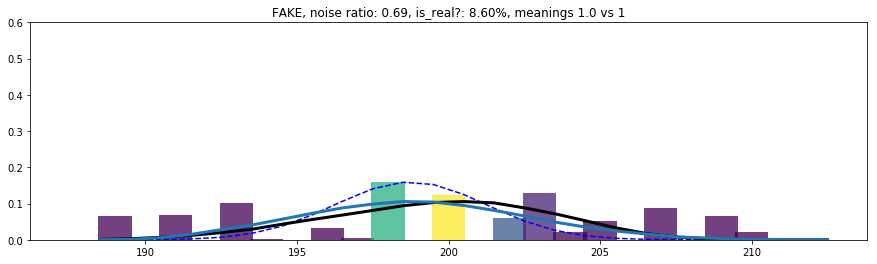

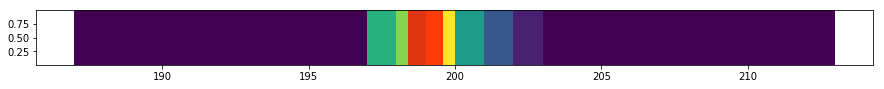

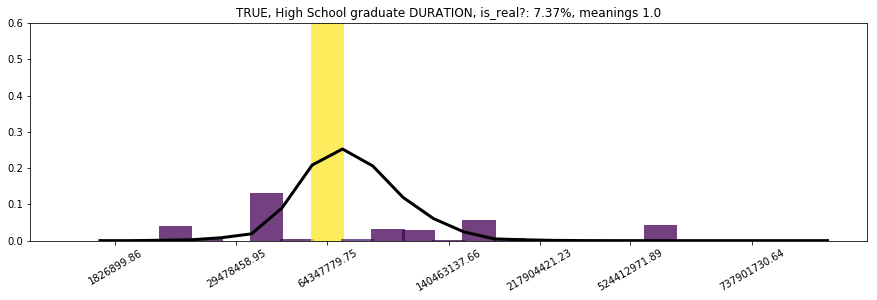

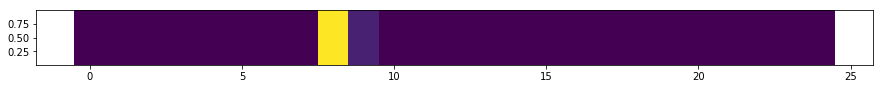

iter: 305, completed: 9.57%, smoother_loss: 1.2066, deconv_loss: 566.9184, smoother_reg: 0.0068, deconv_reg: 0.0048, peaks_loss: 0.8528, mn_loss: 0.1495, ro_pen: 0.0442
Smother | wts: (-14.41, 2.23)
Deconv | wts: (-4.83, 1.36)
iter: 310, completed: 9.73%, smoother_loss: 1.2071, deconv_loss: 568.9995, smoother_reg: 0.0068, deconv_reg: 0.0047, peaks_loss: 0.8556, mn_loss: 0.1492, ro_pen: 0.0430
Smother | wts: (-14.41, 2.23)
Deconv | wts: (-4.83, 1.36)
iter: 315, completed: 9.89%, smoother_loss: 1.1966, deconv_loss: 566.6230, smoother_reg: 0.0067, deconv_reg: 0.0047, peaks_loss: 0.8492, mn_loss: 0.1476, ro_pen: 0.0415
Smother | wts: (-14.41, 2.23)
Deconv | wts: (-4.83, 1.36)
iter: 320, completed: 10.04%, smoother_loss: 1.1999, deconv_loss: 566.7062, smoother_reg: 0.0067, deconv_reg: 0.0047, peaks_loss: 0.8509, mn_loss: 0.1502, ro_pen: 0.0408
Smother | wts: (-14.41, 2.23)
Deconv | wts: (-4.83, 1.37)
error with  243 bins
iter: 325, completed: 10.20%, smoother_loss: 1.2001, deconv_loss: 569.

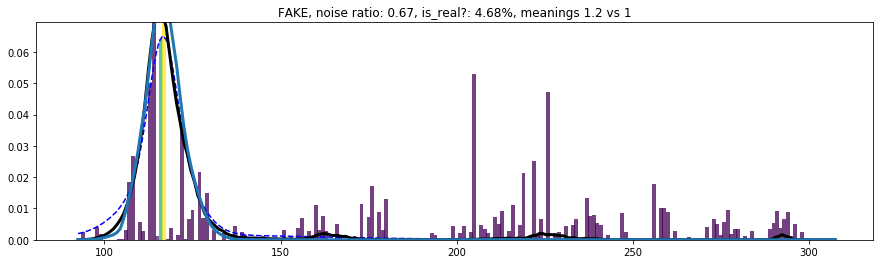

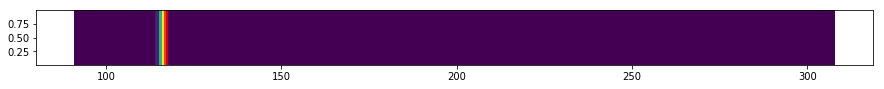

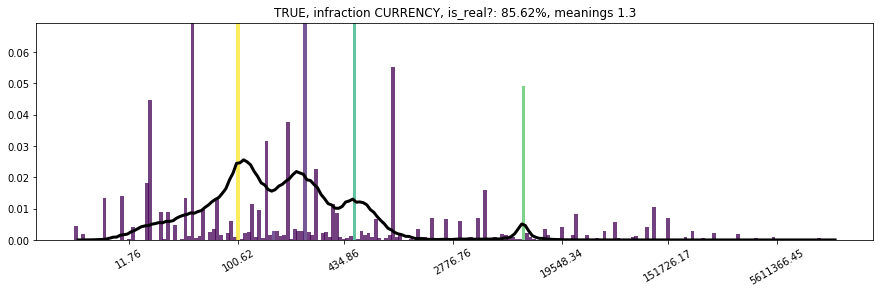

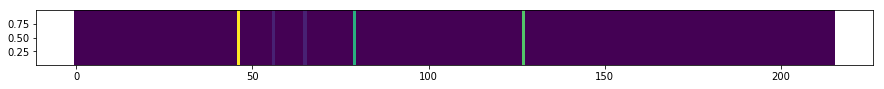

error with  290 bins
iter: 330, completed: 10.36%, smoother_loss: 1.1962, deconv_loss: 567.5886, smoother_reg: 0.0066, deconv_reg: 0.0047, peaks_loss: 0.8505, mn_loss: 0.1496, ro_pen: 0.0400
Smother | wts: (-14.40, 2.22)
Deconv | wts: (-4.84, 1.37)
iter: 335, completed: 10.51%, smoother_loss: 1.2030, deconv_loss: 568.2646, smoother_reg: 0.0065, deconv_reg: 0.0046, peaks_loss: 0.8535, mn_loss: 0.1525, ro_pen: 0.0416
Smother | wts: (-14.40, 2.22)
Deconv | wts: (-4.84, 1.37)
iter: 340, completed: 10.67%, smoother_loss: 1.1945, deconv_loss: 566.4914, smoother_reg: 0.0065, deconv_reg: 0.0046, peaks_loss: 0.8477, mn_loss: 0.1504, ro_pen: 0.0417
Smother | wts: (-14.40, 2.22)
Deconv | wts: (-4.83, 1.37)
iter: 345, completed: 10.83%, smoother_loss: 1.1938, deconv_loss: 566.2889, smoother_reg: 0.0066, deconv_reg: 0.0046, peaks_loss: 0.8508, mn_loss: 0.1483, ro_pen: 0.0406
Smother | wts: (-14.40, 2.22)
Deconv | wts: (-4.83, 1.37)
error with  257 bins
iter: 350, completed: 10.98%, smoother_loss: 1

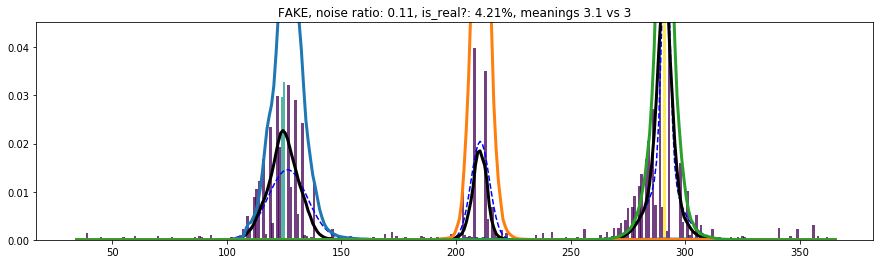

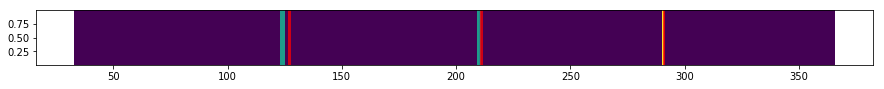

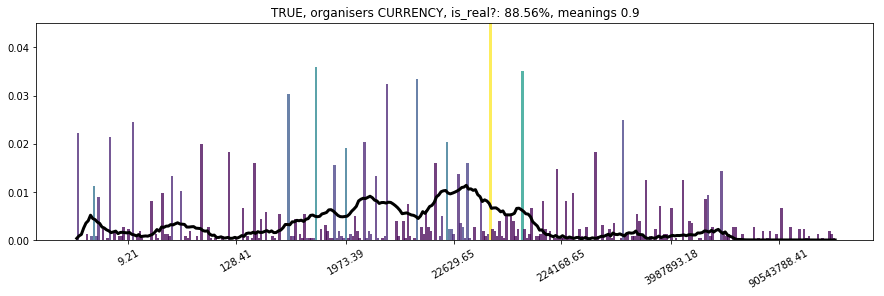

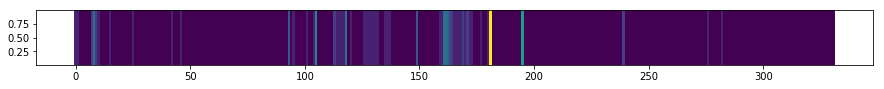

iter: 355, completed: 11.14%, smoother_loss: 1.1820, deconv_loss: 566.0544, smoother_reg: 0.0065, deconv_reg: 0.0046, peaks_loss: 0.8441, mn_loss: 0.1456, ro_pen: 0.0388
Smother | wts: (-14.40, 2.22)
Deconv | wts: (-4.83, 1.37)
iter: 360, completed: 11.30%, smoother_loss: 1.2289, deconv_loss: 566.1892, smoother_reg: 0.0064, deconv_reg: 0.0046, peaks_loss: 0.8552, mn_loss: 0.1740, ro_pen: 0.0451
Smother | wts: (-14.40, 2.22)
Deconv | wts: (-4.83, 1.37)
iter: 365, completed: 11.45%, smoother_loss: 1.2453, deconv_loss: 565.3499, smoother_reg: 0.0063, deconv_reg: 0.0046, peaks_loss: 0.8633, mn_loss: 0.1792, ro_pen: 0.0451
Smother | wts: (-14.39, 2.22)
Deconv | wts: (-4.83, 1.37)
error with  454 bins
iter: 370, completed: 11.61%, smoother_loss: 1.2564, deconv_loss: 567.1387, smoother_reg: 0.0065, deconv_reg: 0.0046, peaks_loss: 0.8684, mn_loss: 0.1830, ro_pen: 0.0451
Smother | wts: (-14.39, 2.21)
Deconv | wts: (-4.83, 1.37)
iter: 375, completed: 11.76%, smoother_loss: 1.2530, deconv_loss: 5

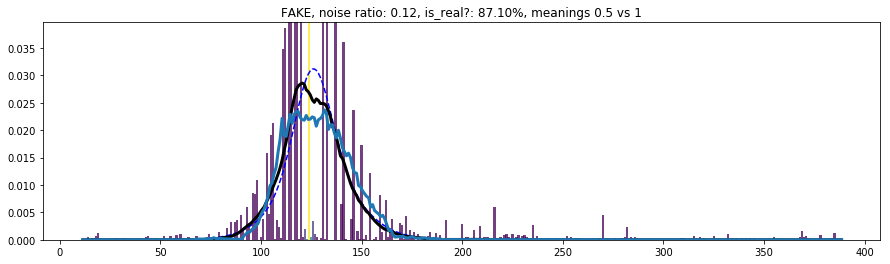

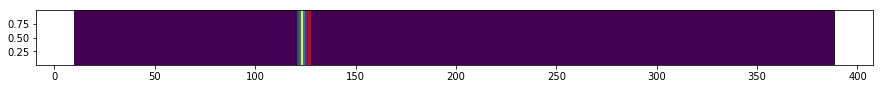

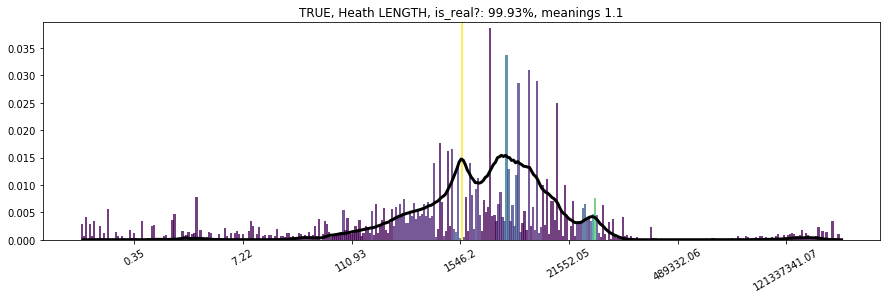

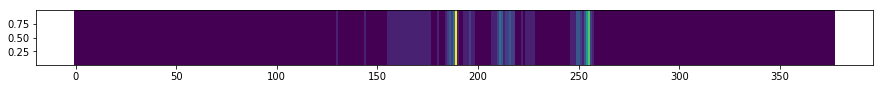

iter: 380, completed: 11.92%, smoother_loss: 1.2507, deconv_loss: 567.2461, smoother_reg: 0.0065, deconv_reg: 0.0046, peaks_loss: 0.8665, mn_loss: 0.1804, ro_pen: 0.0430
Smother | wts: (-14.39, 2.21)
Deconv | wts: (-4.83, 1.37)
iter: 385, completed: 12.08%, smoother_loss: 1.2424, deconv_loss: 566.9474, smoother_reg: 0.0066, deconv_reg: 0.0047, peaks_loss: 0.8632, mn_loss: 0.1781, ro_pen: 0.0417
Smother | wts: (-14.39, 2.21)
Deconv | wts: (-4.83, 1.37)
error with  367 bins
iter: 390, completed: 12.23%, smoother_loss: 1.2441, deconv_loss: 566.9184, smoother_reg: 0.0067, deconv_reg: 0.0047, peaks_loss: 0.8652, mn_loss: 0.1780, ro_pen: 0.0411
Smother | wts: (-14.39, 2.21)
Deconv | wts: (-4.83, 1.36)
iter: 395, completed: 12.39%, smoother_loss: 1.2374, deconv_loss: 565.6945, smoother_reg: 0.0067, deconv_reg: 0.0046, peaks_loss: 0.8621, mn_loss: 0.1766, ro_pen: 0.0398
Smother | wts: (-14.39, 2.21)
Deconv | wts: (-4.83, 1.36)
iter: 400, completed: 12.55%, smoother_loss: 1.2352, deconv_loss: 5

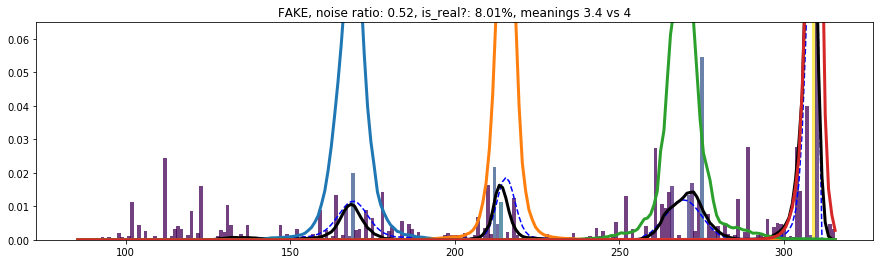

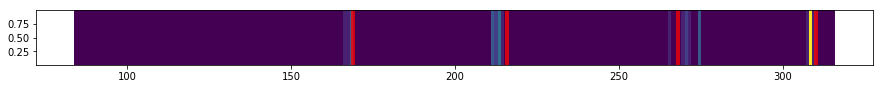

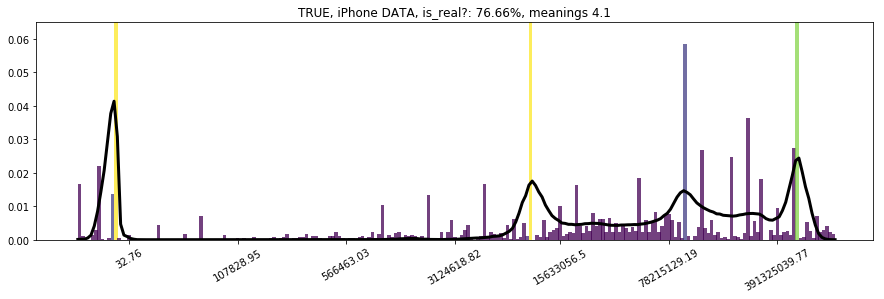

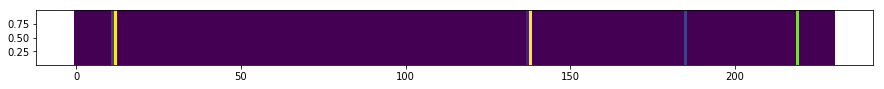

iter: 405, completed: 12.70%, smoother_loss: 1.2289, deconv_loss: 563.9210, smoother_reg: 0.0069, deconv_reg: 0.0046, peaks_loss: 0.8601, mn_loss: 0.1722, ro_pen: 0.0377
Smother | wts: (-14.39, 2.21)
Deconv | wts: (-4.83, 1.36)
iter: 410, completed: 12.86%, smoother_loss: 1.2271, deconv_loss: 563.8465, smoother_reg: 0.0069, deconv_reg: 0.0046, peaks_loss: 0.8613, mn_loss: 0.1707, ro_pen: 0.0368
Smother | wts: (-14.39, 2.21)
Deconv | wts: (-4.83, 1.36)
iter: 415, completed: 13.02%, smoother_loss: 1.2216, deconv_loss: 563.8446, smoother_reg: 0.0070, deconv_reg: 0.0045, peaks_loss: 0.8607, mn_loss: 0.1669, ro_pen: 0.0359
Smother | wts: (-14.39, 2.21)
Deconv | wts: (-4.83, 1.36)
iter: 420, completed: 13.17%, smoother_loss: 1.2220, deconv_loss: 563.8490, smoother_reg: 0.0070, deconv_reg: 0.0047, peaks_loss: 0.8622, mn_loss: 0.1651, ro_pen: 0.0360
Smother | wts: (-14.39, 2.21)
Deconv | wts: (-4.83, 1.36)
iter: 425, completed: 13.33%, smoother_loss: 1.2181, deconv_loss: 564.2733, smoother_reg

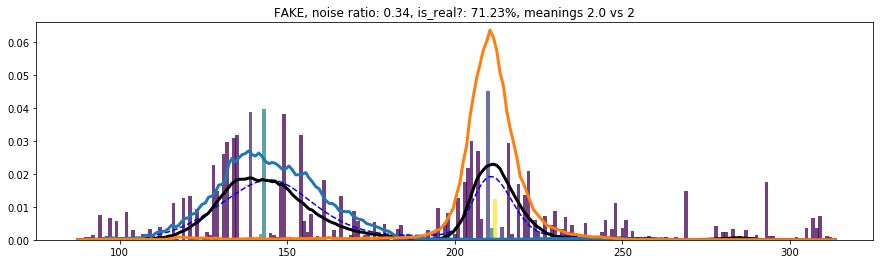

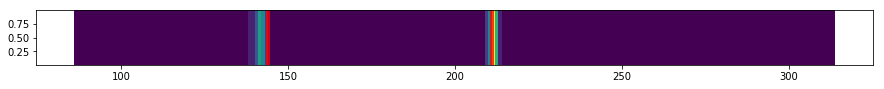

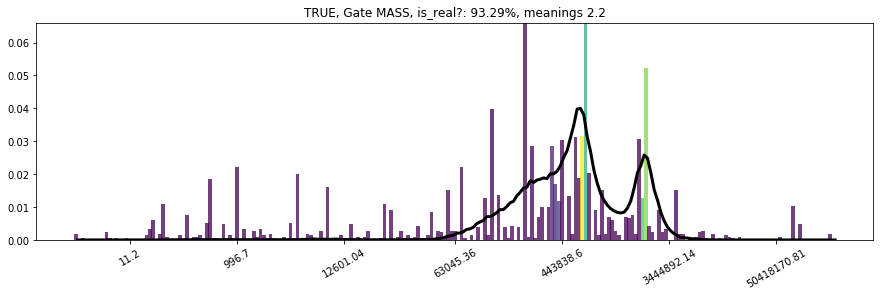

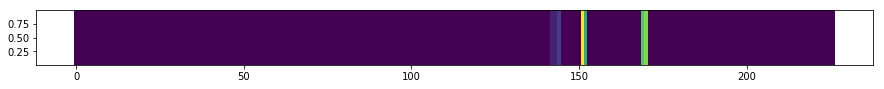

iter: 430, completed: 13.49%, smoother_loss: 1.2144, deconv_loss: 565.9840, smoother_reg: 0.0071, deconv_reg: 0.0048, peaks_loss: 0.8590, mn_loss: 0.1624, ro_pen: 0.0354
Smother | wts: (-14.38, 2.21)
Deconv | wts: (-4.83, 1.36)
iter: 435, completed: 13.64%, smoother_loss: 1.2128, deconv_loss: 568.0372, smoother_reg: 0.0072, deconv_reg: 0.0048, peaks_loss: 0.8615, mn_loss: 0.1597, ro_pen: 0.0347
Smother | wts: (-14.38, 2.21)
Deconv | wts: (-4.83, 1.36)
iter: 440, completed: 13.80%, smoother_loss: 1.2057, deconv_loss: 567.5720, smoother_reg: 0.0071, deconv_reg: 0.0048, peaks_loss: 0.8566, mn_loss: 0.1586, ro_pen: 0.0345
Smother | wts: (-14.38, 2.21)
Deconv | wts: (-4.83, 1.36)
iter: 445, completed: 13.95%, smoother_loss: 1.1999, deconv_loss: 565.7894, smoother_reg: 0.0071, deconv_reg: 0.0047, peaks_loss: 0.8560, mn_loss: 0.1564, ro_pen: 0.0335
Smother | wts: (-14.38, 2.20)
Deconv | wts: (-4.83, 1.36)
iter: 450, completed: 14.11%, smoother_loss: 1.2028, deconv_loss: 570.5233, smoother_reg

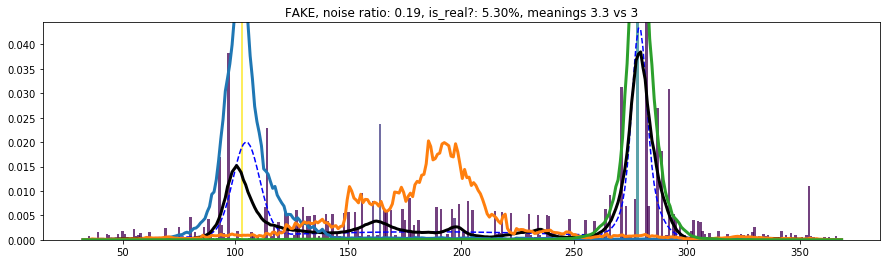

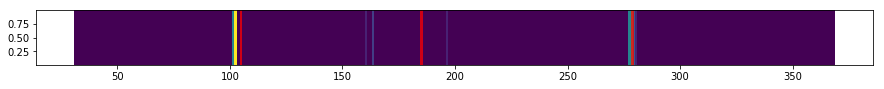

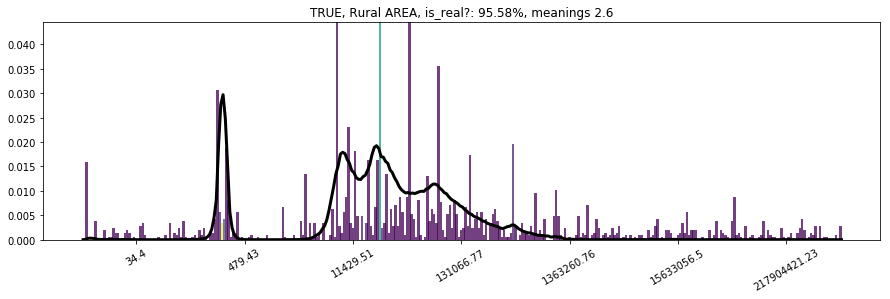

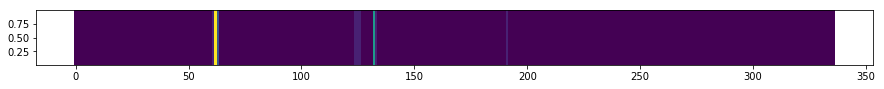

iter: 455, completed: 14.27%, smoother_loss: 1.2022, deconv_loss: 571.1437, smoother_reg: 0.0071, deconv_reg: 0.0046, peaks_loss: 0.8629, mn_loss: 0.1547, ro_pen: 0.0331
Smother | wts: (-14.38, 2.20)
Deconv | wts: (-4.83, 1.36)
iter: 460, completed: 14.42%, smoother_loss: 1.2057, deconv_loss: 571.6448, smoother_reg: 0.0071, deconv_reg: 0.0045, peaks_loss: 0.8627, mn_loss: 0.1559, ro_pen: 0.0363
Smother | wts: (-14.38, 2.20)
Deconv | wts: (-4.83, 1.36)
iter: 465, completed: 14.58%, smoother_loss: 1.2245, deconv_loss: 571.5631, smoother_reg: 0.0071, deconv_reg: 0.0046, peaks_loss: 0.8674, mn_loss: 0.1692, ro_pen: 0.0368
Smother | wts: (-14.38, 2.21)
Deconv | wts: (-4.83, 1.36)


KeyboardInterrupt: 

In [13]:
print_every = 5
plot_every = 25
save_every = 100
save_ckpt = 1000
# num_ckpt = 0
num_ckpt = 300
lam = 0.01
epochs = 10
entries_per_file = 64
batches_per_file = entries_per_file // BATCHSIZE
total_iter = batches_per_file * len(files)
np.random.shuffle(files)


for epoch in range(epochs):
    print(f"===== Epoch {epoch}: =====")
    i = 0
    for file in files:
        file_data = read_batch(file)
        np.random.shuffle(file_data)
        for b in range(batches_per_file):
            batch = file_data[b*BATCHSIZE:(b + 1)*BATCHSIZE]
            if len(batch) < BATCHSIZE:
#                 print(f"Skipping batch {b} from file {file}")
                continue
            x, z, s, nr, modes, bs, x_stacked, s_stacked, modes_stacked, bs_stacked, num_meanings, generated_images, generated_images_stacked = get_inputs(batch)
            x_ = tf.convert_to_tensor(x, tf.float32)
            z_ = tf.convert_to_tensor(z, tf.float32)
            s_ = tf.convert_to_tensor(s, tf.float32)
            nr_ = tf.convert_to_tensor(nr, tf.float32)
            modes_ = tf.convert_to_tensor(modes, tf.float32)
            bs_ = tf.convert_to_tensor(bs, tf.float32)
            x_stacked_ = tf.convert_to_tensor(x_stacked, tf.float32)
            s_stacked_ = tf.convert_to_tensor(s_stacked, tf.float32)
            modes_stacked_ = tf.convert_to_tensor(modes_stacked, tf.float32)
            bs_stacked_ = tf.convert_to_tensor(bs_stacked, tf.float32)
            nm_ = tf.convert_to_tensor(np.reshape(num_meanings, (-1, 1)), tf.float32)
            gi_ = tf.convert_to_tensor(generated_images, tf.float32)
            gi_stacked_ = tf.convert_to_tensor(generated_images_stacked, tf.float32)
            try:
                sm_loss, deconv_loss, sm_reg, deconv_reg, peaks_loss, mn_loss, ro_pen = train_step(
                    x_, z_, s_, nr_, modes_, bs_, gi_, nm_, x_stacked_, s_stacked_, modes_stacked_, bs_stacked_, gi_stacked_)
            except tf.errors.InvalidArgumentError as e:
                print(e)
                print("file ", file)
#                 print("x row sum: ", np.sum(np.squeeze(x), 1))
#                 print("x row min", np.min(np.squeeze(x), 1))
#                 print("x row max", np.max(np.squeeze(x), 1))
#                 print("x na?", np.any(np.squeeze(np.isnan(x)), 1))
                
                continue

            # record losses
            if not first_run:
                sm_loss_ += lam * (sm_loss.numpy() - sm_loss_)
                deconv_loss_ += lam * (deconv_loss.numpy() - deconv_loss_)
                sm_reg_ += lam * (sm_reg.numpy() - sm_reg_)
                deconv_reg_ += lam * (deconv_reg.numpy() - deconv_reg_)
                peaks_loss_ += lam * (peaks_loss.numpy() - peaks_loss_)
                mn_loss_ += lam * (mn_loss.numpy() - mn_loss_)
                ro_pen_ += lam * (ro_pen.numpy() - ro_pen_)                
            else:
                sm_loss_ = sm_loss.numpy()
                deconv_loss_ = deconv_loss.numpy()
                sm_reg_ = sm_reg.numpy()
                deconv_reg_ = deconv_reg.numpy()
                peaks_loss_ = peaks_loss.numpy()
                mn_loss_ = mn_loss.numpy()
                ro_pen_ = ro_pen.numpy()
                first_run = False
                
            # print
            if i % print_every == 0:
                fr = f"iter: {i}, completed: {100.0 * (i + 1) / total_iter:.2f}%"
                sl = f"smoother_loss: {sm_loss_:.4f}"
                dl = f"deconv_loss: {deconv_loss_:.4f}"
                slr = f"smoother_reg: {sm_reg_:.4f}"
                dlr = f"deconv_reg: {deconv_reg_:.4f}"
                pl = f"peaks_loss: {peaks_loss_:.4f}"
                ml = f"mn_loss: {mn_loss_:.4f}"
                rl = f"ro_pen: {ro_pen_:.4f}"
                msg = f"{fr}, {sl}, {dl}, {slr}, {dlr}, {pl}, {ml}, {rl}"
                print(msg)
                print_checks(smoother, "Smother")
                print_checks(deconv, "Deconv")
            

            if i % plot_every == 0:
                obs, start = standardize_bins(batch[0]["counts"])
                n_bins = len(batch[0]["counts"])
                x0 = np.expand_dims(x[0, :, :], 0).astype(np.float32)
                modes_ = np.squeeze(modes[0, :, :]).astype(np.float32)
                modes_locs = np.where(modes_ > 0.0)[0]
                z0 = np.expand_dims(z[0, :, :], 0).astype(np.float32)
                s0 = np.expand_dims(s[0, :, :], 0).astype(np.float32)
                nr0 = np.expand_dims(nr[0, :, :], 0).astype(np.float32)
                b0 = np.expand_dims(bs_[0, :, :], 0).astype(np.float32)
                pdf = np.squeeze(s0)        
                pdf_normalized = s0 * b0  # np.sqrt(b0)
                fake = generator([z0, pdf_normalized, nr0], training=False)
                fake_normalized = fake * b0  # np.sqrt(b0)
                pred, peaks = smoother(fake_normalized, training=False)
                fake = np.squeeze(fake.numpy())
                pred = np.squeeze(pred.numpy())
                peaks = np.squeeze(peaks.numpy())
                peaks = 1.0 / (1.0 + np.exp(-peaks))
                if np.any(np.isnan(fake)) or np.any(np.isnan(peaks)) or np.any(np.isnan(pred)):
                    pdb.set_trace()
                in_range = np.where(fake > 1e-3)[0]
#                 h = np.arange(in_range[0], in_range[-1])
#                 h = np.arange(0, MAXBINS)
                h = np.arange(start, min(MAXBINS, start + n_bins))
                # FAKE IMAGE
                plt.figure(figsize=(15, 4))
                bcol = (peaks[h] - min(peaks[h])) / (max(peaks[h]) - min(peaks[h]))
                plt.bar(h, fake[h], width=1.1, alpha=0.75, color=viridis(bcol))
                plt.plot(h + 0.5, pdf[h], c="blue", ls="dashed")
                plt.plot(h + 0.5, pred[h], c="black", lw=3)
                u = pred[h]
                plt.ylim(0, 15 * np.mean(u[u > 0]))
                discat = discriminator(fake_normalized, training=False)
                discat = discat.numpy().item()
                discat = 1.0 / (1.0 + np.exp(-discat))
                pred_meanings = sum(peaks)
                true_meanings = num_meanings[0]
                leg_meanings = f"meanings {pred_meanings:.1f} vs {true_meanings}"
                plt.title(f"FAKE, noise ratio: {nr0[0,0,0]:.2f}, is_real?: {100 * discat:.2f}%, {leg_meanings}")
                # add contexts
                for v, mm in enumerate(modes_locs):
                    u = np.zeros((1, MAXBINS, 1), dtype=np.float32)
                    u[0, mm, 0] = 1.0
                    u = np.concatenate([fake_normalized, u], -1)
                    dec_output = np.squeeze(deconv(u).numpy())
                    plt.plot(h + 0.5, dec_output[h], lw=3)                    
                plt.show()
                plt.figure(figsize=(15, 1))
                plt.bar(h, np.ones_like(h), width=2.0, alpha=1.0, color=viridis(bcol))
                plt.ylim(0.01, 0.99)
                plt.bar(modes_locs, np.ones_like(modes_locs), width=1.2, color="red", alpha=0.75)
                plt.show()
                # REAL IMAGE
                plt.figure(figsize=(15, 4))
                x_normalized = x0 * b0  # np.sqrt(b0)
                pred, peaks = smoother(x_normalized, training=False)
                pred = np.squeeze(pred.numpy())
                peaks = np.squeeze(peaks.numpy())
                peaks = 1.0 / (1.0 + np.exp(-peaks))
                real = np.squeeze(x0)
                in_range = np.where(real > 1e-3)[0]
                h0 = np.arange(len(h))
                bcol = (peaks[h] - min(peaks[h])) / (max(peaks[h]) - min(peaks[h]))
                plt.bar(h0, real[h], width=1.1, alpha=0.75, color=viridis(bcol))
                plt.plot(h0 + 0.5, pred[h], c="black", lw=3)
                u = pred[h]
                plt.ylim(0, 15 * np.mean(u[u > 0]))
                discat = discriminator(x_normalized, training=False).numpy().item()
                discat = 1.0 / (1.0 + np.exp(-discat))
                obj = batch[0]['obj']
                dim = batch[0]['dim']
                pred_meanings = sum(peaks)
                leg_meanings = f"meanings {pred_meanings:.1f}"
                plt.title(f"TRUE, {obj} {dim}, is_real?: {100 * discat:.2f}%, {leg_meanings}")
                locs = [int((i + 0.5) * (n_bins - 1)) // 7 for i in range(7)]
                middle = 0.5 * (np.array(batch[0]['loglower']) + np.array(batch[0]['logupper']))
                labs = [np.round(10 ** middle[j], 2) for j in locs]
                plt.xticks(locs, labs, rotation=30)
                plt.show()
                plt.figure(figsize=(15, 1))
                plt.bar(h0, np.ones_like(h), width=1.0, alpha=1.0, color=viridis(bcol))
                plt.ylim(0.01, 0.99)
                plt.show()


            if (i + 1) % save_every == 0:
                smoother.save_weights("smoother_post_gan_bi.h5")
                deconv.save_weights("deconv_post_gan_bi.h5")
                
            if (i + 1) % save_ckpt == 0:
                fname_g = f"ckpts2/smoother_post_gan_{num_ckpt:04d}.h5"
                smoother.save_weights(fname_g)
                fname_d = f"ckpts2/deconv_post_gan_{num_ckpt:04d}.h5"
                deconv.save_weights(fname_d)
                num_ckpt += 1
                
            i += 1
            

In [ ]:
for w in smoother.weights:
    if np.any(np.isnan(w.numpy())):
        print(w.name)

In [77]:
first_run = True